In [2]:
# Adds SIFT and SURF functionalities.
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

In [3]:
from pathlib import Path
import os
import pandas as pd
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin

# Utilities

In [4]:
import time

class codeTimer:
    """
    Context manager, measures and prints the execution time of a function.
    """
    
    def __init__(self, name=None):
        self.name = "Executed '"  + name + "'. " if name else ""

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, exc_type, exc_value, traceback):
        self.end = time.perf_counter()
        self.elapsed = (self.end - self.start)
        print('%s Elapsed time: %0.6fs' % (str(self.name), self.elapsed))

# Read and compute descriptors

In [5]:
# Read image and directory (image category)

def read_image(dir_path):
    """
    TBD iterator
    """
    
    for subdir, dirs, files in os.walk(dir_path):
        for file in files:
            # Ignore useless files.
            if file != ".DS_Store":
                yield (os.path.join(subdir, file),
                       os.path.basename(subdir))
                

def compute_descriptors(dir_path):
    """
    TBD, note on ORB instead of SIFT/SURF
    """
    
    # Lists to contain data.
    image_ids = []
    descriptors = []
    labels = []
    
    #images_names = []
    
    # Build SIFT object.
    orb = cv2.xfeatures2d.SIFT_create()
    
    image_id = 0
    
    for image, label in read_image(dir_path):
        # Detect and compute keypoints and descriptors.
        kp, des = orb.detectAndCompute(cv2.imread(image), None)
        # If no keypoints detected, continue.
        if kp == []:
            continue
        for d in range(len(des)):
            descriptors.append(des[d])
            image_ids.append(image_id)
            labels.append(label)
            #images_names.append(image)
            
        image_id += 1
            
    des_df = pd.DataFrame(columns = ['image_id', 'descriptor', 'label'])
    des_df['image_id'] = image_ids
    des_df['descriptor'] = descriptors
    des_df['label'] = labels
    
    #des_df['names'] = images_names
    
    
    return des_df

# Kmeans and historgams

In [6]:
def k_means_words(descriptors_df, n_clusters, num_descriptors):
    """
    TBD
    """
    
    # Sample `num_descriptors` descriptors.
    data = descriptors_df['descriptor'].sample(n = num_descriptors).tolist()
    print("Number of sampled descriptors: {}".format(len(data)))
    # Compute the kmeans algorithm on the sampled descriptors.
    kmeans = KMeans(n_clusters = n_clusters, n_jobs = -1).fit(data)
    print("Clustered the descriptors in {} clusters".format(kmeans.n_clusters))
    return kmeans

In [7]:
def find_nearest_term(descriptor, dictionary):
    """
    TBD
    """
    distances = [lin.norm(descriptor - term) for term in dictionary]
    
    return np.argmin(distances)

def compute_histogram(descriptors_df, kmeans):
    """
    TBD
    """
    # Estract visual words (centroids) from kmeans computation.
    dictionary = kmeans.cluster_centers_
    
    num_images = len(descriptors_df['image_id'])
    histograms = np.zeros((num_images, len(dictionary)))
    
    # For every image.
    for index, row in descriptors_df.iterrows():
        # For every descriptor.
        for descriptor in row['descriptor']:
            closest_centroid = find_nearest_term(descriptor, dictionary)
            histograms[index][closest_centroid] += 1
            
    # Compute norms and normalisation.
    norm = np.sum(histograms, axis = 1).reshape(num_images, 1)
    histograms = histograms / norm
    
    # More convenient format as list of arrays.
    histograms = list(histograms[row] for row in range(len(histograms)))
    
    return histograms

# Classifiers

In [8]:
from scipy.stats import wasserstein_distance

def nn_classifier(train_df, test_df):
    true_labels = test_df['label']
    predicted_labels = []
    
    # For each test image.
    for test_index, test_row in test_df.iterrows():
        distances = []
        # Compute distance with each train image.
        for train_index, train_row in train_df.iterrows():
            distances.append(wasserstein_distance(train_row['histogram'],
                                                  test_row['histogram']))
        # The predicted label corresponds to the minimum distance.
        predicted_labels.append(train_df.iloc[np.argmin(distances)]['label'])
        
    return true_labels, predicted_labels

In [9]:
from sklearn.svm import SVC

def linear_SVM_classifier(train_df, test_df):
    
    true_labels = test_df['label']
    predicted_labels = []
    
    # Training multiclass SVM, one-vs-rest approach.
    
    # Extract labels.
    train_labels = train_df['label'].to_numpy()
    classes = train_df['label'].unique()

    # Extract histograms, (n_samples, n_feature) numpy array.
    histo = np.asarray(train_df['histogram'].tolist())

    # Build a classifier for each class.
    clf = [SVC(kernel = 'linear') for _ in range(len(classes))]

    # Fit each of the classifiers.
    for idx, c in enumerate(clf):
        current_label = classes[idx]
        # 1 for current_label occurrences, -1 elsewhere.
        target = np.array(["1" if  label == current_label else "-1" for label in train_labels])
        c = c.fit(histo, target)
        
    # Predicting label for each test image.
    
    for test_index, test_row in test_df.iterrows():
        distances = []
        # Compute real valued score with each classifier.
        for idx, c in enumerate(clf):
            # Compute distances from hyperplanes
            distances.append(c.decision_function(test_row['histogram'].reshape(1, -1) / 
                                                 lin.norm(c.coef_)))
        # The predicted label corresponds to the maximum distance from hyperplane.
        predicted_labels.append(classes[np.argmax(distances)])
    
    
    return true_labels, predicted_labels

In [49]:
def chi_2_distance(hist_1, hist_2):
    # Note, not using the cv2 formula since it is not really a distance.
    n_bins = len(hist_1)
    
    non_zero = [index for index in range(n_bins)
                if (hist_1[index] != 0 and hist_2[index] != 0)]
    
    distance = 0.5 * np.sum((hist_1[non_zero] - hist_2[non_zero])**2 /
                            (hist_1[non_zero] + hist_2[non_zero]))
    
    return distance

In [62]:
def gaussian_kernel(hist_1, hist_2, dist_function, sigma = 0.1):
    distance = dist_function(hist_1, hist_2)
    return np.exp( - distance / (2 * sigma ** 2 ))

In [119]:
def gram_matrix(histograms_1, histograms_2,
                kernel_function = gaussian_kernel,
                dist_function = chi_2_distance):
    
    gram = np.zeros((histograms_1.shape[0], histograms_2.shape[0]))
    
    for i, h_1 in enumerate(histograms_1):
        for j, h_2 in enumerate(histograms_2):
            elem = kernel_function(h_1, h_2, dist_function)
            gram[i, j] = elem
    
    return gram

In [131]:
from sklearn.multiclass import OneVsRestClassifier

def gaussian_SVM_classifier(train_df, test_df, kernel_function = gaussian_kernel,
                            dist_function = chi_2_distance):
    
    
    true_labels = test_df['label']
    predicted_labels = []
    
    # Training multiclass SVM, one-vs-rest approach.
    
    # Extract labels and histograms.
    train_labels = train_df['label'].to_numpy()
    classes = train_df['label'].unique()
    train_histograms = train_df['histogram']
    
    # Build classifier.
    gram = gram_matrix(train_histograms, train_histograms,
                       kernel_function, dist_function)
    clf = OneVsRestClassifier(SVC(kernel="precomputed"), n_jobs=-1)
    clf.fit(gram, train_labels)
    
    # Predicting label for each test image.
    test_histograms = test_df['histogram']
    prediction_gram = gram_matrix(test_histograms, train_histograms,
                                  kernel_function, dist_function)
    predicted_labels = clf.predict(prediction_gram)
    
    return true_labels, predicted_labels

In [105]:
len(gram)

1500

In [106]:
train_labels = train_df['label'].to_numpy()
classes = train_df['label'].unique()
clf = OneVsRestClassifier(SVC(kernel="precomputed"), n_jobs=-1)
clf.fit(gram, train_labels)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='precomputed',
                                  max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=-1)

In [117]:
test_histograms = test_df['histogram']

In [121]:
pred_gram = gram_matrix(hii, test_histograms)

In [124]:
predicted_lables = clf.predict(pred_gram.T)

In [128]:
len(predicted_lables)

2985

In [132]:
true, predicted = gaussian_SVM_classifier(train_df, test_df)

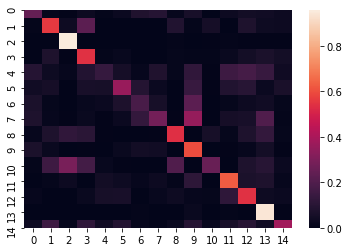

In [133]:
conmat = confusion_matrix(true, predicted)
conmat = conmat / np.sum(conmat, axis = 1)
sn.heatmap(conmat)

In [134]:
np.sum(np.diag(conmat)) / np.sum(conmat)

0.45715037346017845

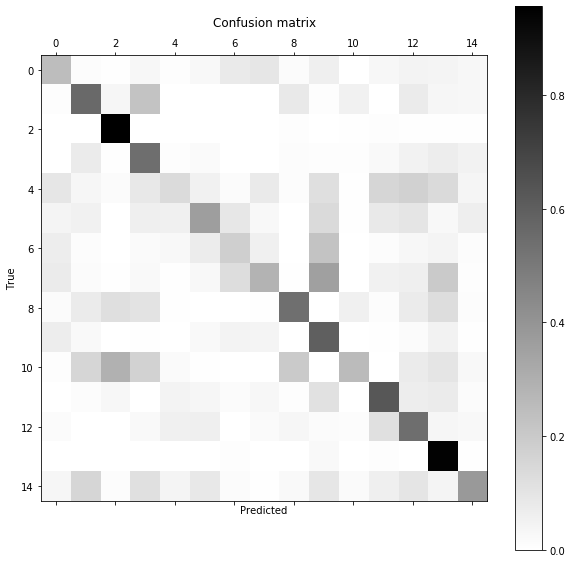

In [135]:
plot_confusion_matrix(true, predicted)

In [94]:
hist1 = train_df["histogram"][0]
hist2 = train_df["histogram"][2]
    
chi_2_distance(hist1, hist2)

0.213844469313858

In [95]:
gaussian_kernel(hist1, hist2, chi_2_distance)

2.272094286363017e-05

In [114]:
hii = train_df['histogram']
gram = gram_matrix(hii, hii, gaussian_kernel, chi_2_distance)

In [115]:
gram

array([[1.00000000e+00, 5.48962426e-03, 2.27209429e-05, ...,
        1.06855279e-05, 3.36100356e-06, 3.86524216e-03],
       [5.48962426e-03, 1.00000000e+00, 1.60854697e-04, ...,
        2.66623673e-05, 3.42534046e-08, 3.90862323e-03],
       [2.27209429e-05, 1.60854697e-04, 1.00000000e+00, ...,
        1.58490432e-05, 5.12689695e-06, 1.49887492e-06],
       ...,
       [1.06855279e-05, 2.66623673e-05, 1.58490432e-05, ...,
        1.00000000e+00, 1.14841248e-06, 6.32137626e-04],
       [3.36100356e-06, 3.42534046e-08, 5.12689695e-06, ...,
        1.14841248e-06, 1.00000000e+00, 3.11180342e-05],
       [3.86524216e-03, 3.90862323e-03, 1.49887492e-06, ...,
        6.32137626e-04, 3.11180342e-05, 1.00000000e+00]])

In [101]:
gram

array([[1.00000000e+00, 5.48962426e-03, 2.27209429e-05, ...,
        1.06855279e-05, 3.36100356e-06, 3.86524216e-03],
       [5.48962426e-03, 1.00000000e+00, 1.60854697e-04, ...,
        2.66623673e-05, 3.42534046e-08, 3.90862323e-03],
       [2.27209429e-05, 1.60854697e-04, 1.00000000e+00, ...,
        1.58490432e-05, 5.12689695e-06, 1.49887492e-06],
       ...,
       [1.06855279e-05, 2.66623673e-05, 1.58490432e-05, ...,
        1.00000000e+00, 1.14841248e-06, 6.32137626e-04],
       [3.36100356e-06, 3.42534046e-08, 5.12689695e-06, ...,
        1.14841248e-06, 1.00000000e+00, 3.11180342e-05],
       [3.86524216e-03, 3.90862323e-03, 1.49887492e-06, ...,
        6.32137626e-04, 3.11180342e-05, 1.00000000e+00]])

---

# Main

Example:

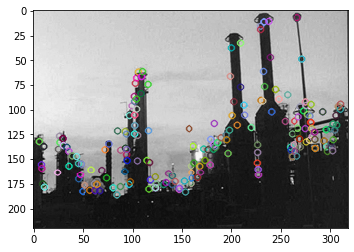

In [11]:
img = cv2.imread("./dataset/train/Industrial/image_0151.jpg")
orb = cv2.xfeatures2d.SIFT_create()
kp = orb.detect(img,None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img,kp,img)
_ = plt.imshow(img2),plt.show()

### Reading images, computing visual words and histograms

Train set:

In [12]:
train_path = "./dataset/train"
test_path = "./dataset/test"

n_clusters = 50 # Size of dictionary.
n_descriptors = 100000

# Read images and compute descriptors, saving them in a dataframe.
with codeTimer("Compute descriptors"):
    train_df = compute_descriptors(train_path)
    
print("Total number of {}-dimensional descriptors: {}"
      .format(len(train_df['descriptor'][0]), len(train_df)))

# Compute kmeans clustering using descriptors to obtain visual dictionary.

# Note: cluster centers are stored in this object,
# and can be obtained using `kmeans.cluster_centers_`.
with codeTimer("Compute k-means words"):
    kmeans = k_means_words(train_df, n_clusters, n_descriptors)
    
# Aggregate descriptor info, making dataframe more compact.
# Now the third column contains the list of descriptors.
train_df = train_df.groupby(['image_id', 'label'],
                            as_index = False).agg({'descriptor':
                                                   (lambda x: list(x))})

# Compute histograms and add them to dataframe.
with codeTimer("Compute histograms"):
    train_histograms = compute_histogram(train_df, kmeans)
    
train_df['histogram'] = train_histograms

Executed 'Compute descriptors'.  Elapsed time: 49.655687s
Total number of 128-dimensional descriptors: 762342
Number of sampled descriptors: 100000
Clustered the descriptors in 50 clusters
Executed 'Compute k-means words'.  Elapsed time: 154.486068s
Executed 'Compute histograms'.  Elapsed time: 355.616017s


Test set:

In [13]:
# Compute histograms for test set, using words extracted from train.

test_df = compute_descriptors(test_path)

test_df = test_df.groupby(['image_id', 'label'],
                            as_index = False).agg({'descriptor':
                                                   (lambda x: list(x))})

# Note, kmeans has not been recomputed, the training one is used.
test_histograms = compute_histogram(test_df, kmeans)
test_df['histogram'] = test_histograms

----
## NN

In [ ]:
with codeTimer("NN classifier"):
    true, predicted = nn_classifier(train_df, test_df)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

In [ ]:
# Storing results to file
#test_df.to_pickle("test_frame")
#train_df.to_pickle("train_frame")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
conmat = confusion_matrix(true, predicted)
conmat = conmat / np.sum(conmat, axis = 1)
sn.heatmap(conmat)

In [ ]:
np.sum(np.diag(conmat)) / np.sum(conmat)

----
## SVM

In [14]:
with codeTimer("Linear SVM classifier"):
    true, predicted = linear_SVM_classifier(train_df, test_df)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'Linear SVM classifier'.  Elapsed time: 31.088738s


In [15]:
def plot_confusion_matrix(true_labels, predicted_labels):
    data = {'True' : true_labels, "Predicted" : predicted_labels}
    
    df = pd.DataFrame(data, columns=['True','Predicted'])
    confusion_matrix = pd.crosstab(df['True'], df['Predicted'], rownames=['True'], colnames=['Predicted']) 
    confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis = 1)
    sn.heatmap(confusion_matrix)

In [16]:
def plot_confusion_matrix(true_labels, predicted_labels, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    data = {'True' : true_labels, "Predicted" : predicted_labels}
    
    df = pd.DataFrame(data, columns=['True','Predicted'])
    df_confusion = pd.crosstab(df['True'], df['Predicted'], rownames=['True'], colnames=['Predicted'])     
    df_confusion = df_confusion / df_confusion.sum(axis = 1)
    
    fig, ax = plt.subplots(figsize=(10,10)) 
    
    im = ax.matshow(df_confusion, cmap=cmap) # imshow
    ax.set_title(title)
    fig.colorbar(im, cmap=cmap)
    #tick_marks = np.arange(len(df_confusion.columns))
    #ax.set_xticks(tick_marks, df_confusion.columns)
    #ax.set_yticks(tick_marks, df_confusion.index)
    ax.set_ylabel(df_confusion.index.name)
    ax.set_xlabel(df_confusion.columns.name)



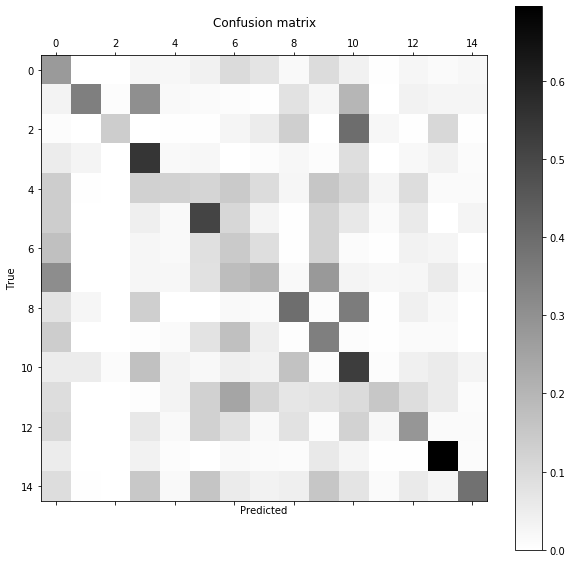

In [17]:
plot_confusion_matrix(true, predicted)

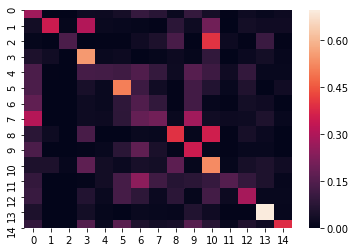

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
conmat = confusion_matrix(true, predicted)
conmat = conmat / np.sum(conmat, axis = 1)
sn.heatmap(conmat)

In [19]:
np.sum(np.diag(conmat)) / np.sum(conmat)

0.32518722652465254